In [1]:
!pip install -q swig
!pip3 install gym[all]
!pip3 install gym[accept-rom-license]
!pip install gym pyvirtualdisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 9.1 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376100 sha256=a5ff3d522ba985af130b488ec0da8212cafe73c861ed78bf77316bf3917e2956
  St

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import matplotlib
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
!apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

In [3]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video', episode_trigger = lambda episode_number: True)
  return env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import random
import math
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import json
import os
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from gym.wrappers import  AtariPreprocessing, FrameStack
from gym.wrappers.frame_stack import LazyFrames
import warnings
warnings.filterwarnings("ignore")

use_cuda = torch.cuda.is_available()

In [5]:
class DQN(nn.Module):
        def __init__(self, channels, num_actions):
            super(DQN, self).__init__()
            self.conv1 = nn.Conv2d(channels, 32, kernel_size=8, stride=4)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
            self.fc = nn.Linear(64*7*7, 512)  # Adjusted input size
            self.head = nn.Linear(512, num_actions)
            self.relu = nn.ReLU()
            self.lrelu = nn.LeakyReLU(0.01)

        def forward(self, x):
            x = x.float()
            x = self.relu(self.conv1(x))
            x = self.relu(self.conv2(x))
            x = self.relu(self.conv3(x))
            # Flatten the tensor before the fully connected layer
            x = x.view(x.size(0), -1)
            x = self.lrelu(self.fc(x))
            q = self.head(x)
            return q

In [6]:
class ReplayBuffer:
    def __init__(self, capacity, batch_size):
        self.capacity = capacity
        self.batch_size = batch_size
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.position = 0

    def store(self, state, action, reward, next_state, done):
        experience = self.experience(state, action, reward, next_state, done)
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        experiences = random.sample(self.buffer, k=self.batch_size)
        states = torch.cat([e.state for e in experiences if e is not None]).float().cuda()
        next_states = torch.cat([e.next_state for e in experiences if e is not None]).float().cuda()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().cuda()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().cuda()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().cuda()
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.buffer)

In [7]:
class AgentDQN():
    def __init__(self, env):
        self.environment = env
        self.input_channels = 4
        self.action_space_size = self.environment.action_space.n
        print('Using Deep Q Network')

        self.online_network = DQN(self.input_channels, self.action_space_size).cuda() if use_cuda else DQN(self.input_channels, self.action_space_size)
        self.target_network = DQN(self.input_channels, self.action_space_size).cuda() if use_cuda else DQN(self.input_channels, self.action_space_size)

        self.target_network.load_state_dict(self.online_network.state_dict())

        self.gamma = 0.99
        self.learning_frequency = 4
        self.total_training_steps = 1000000
        self.learning_start_threshold = 10000
        self.batch_size = 32
        self.target_update_frequency = 1000
        self.display_frequency = 25

        self.optimizer = optim.RMSprop(self.online_network.parameters(), lr=1e-4)

        self.current_step = 0
        self.epsilon_min = 0.025
        self.epsilon_max = 1.0
        self.epsilon_decay_steps = 60000
        self.metrics = {'steps': [], 'rewards': []}

        self.replay_buffer = ReplayBuffer(100000, self.batch_size)
        self.test_actions = []


    def save_model(self, path):
        print(f'Saving model to {path}')
        model_state = {'online': self.online_network.state_dict(), 'target': self.target_network.state_dict()}
        torch.save(model_state, path)

    def load_model(self, path):
        print(f'Loading model from {path}')
        if use_cuda:
            self.online_network.load_state_dict(torch.load(path)['online'])
        else:
            self.online_network.load_state_dict(torch.load(path, map_location=lambda storage, loc: storage)['online'])

    def compute_epsilon(self, step):
        if step > self.epsilon_decay_steps:
            return 0
        else:
            return self.epsilon_min + (self.epsilon_max - self.epsilon_min) * ((self.epsilon_decay_steps - step) / self.epsilon_decay_steps)


    def select_action(self, state, evaluate=False):
        if evaluate:
            if not isinstance(state, torch.Tensor):  # Check if state is not already a tensor
                state = torch.from_numpy(state).unsqueeze(0)
            state = state.cuda() if use_cuda else state
            with torch.no_grad():
                action = self.online_network(state).max(1)[1].item()
        else:
            if random.random() > self.compute_epsilon(self.current_step):
                with torch.no_grad():
                    action = self.online_network(state).max(1)[1].item()
            else:
                action = random.randrange(self.action_space_size)
        return action

    def optimize_model(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample()

        next_q_values = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        rewards = rewards.clamp(-2.0)

        current_q_values = self.online_network(states).gather(1, actions)
        expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = F.mse_loss(current_q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train_agent(self):
        best_reward = 0
        episode_number = 1
        reward_history = []
        loss_history = []

        while self.current_step < self.total_training_steps:
            state = np.array(self.environment.reset())
            state = torch.from_numpy(state).unsqueeze(0)
            state = state.cuda() if use_cuda else state

            done = False
            episode_rewards = []
            episode_losses = []

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _ = self.environment.step(action)
                next_state = np.array(next_state)

                next_state = torch.from_numpy(next_state).unsqueeze(0)
                next_state = next_state.cuda() if use_cuda else next_state

                episode_rewards.append(reward)
                reward_history.append(reward)

                self.replay_buffer.store(state, action, reward, next_state, done)
                state = next_state

                if self.current_step > self.learning_start_threshold and self.current_step % self.learning_frequency == 0:
                    loss = self.optimize_model()
                    episode_losses.append(loss)
                    loss_history.append(loss)

                if self.current_step > self.learning_start_threshold and self.current_step % self.target_update_frequency == 0:
                    self.target_network.load_state_dict(self.online_network.state_dict())

                self.current_step += 1

            avg_loss = sum(episode_losses) / len(episode_losses) if episode_losses else 0
            print(f'Episode: {episode_number} | Steps: {self.current_step}/{self.total_training_steps} | Avg Reward: {sum(episode_rewards)} | Loss: {avg_loss:.4f}', end='\r')

            self.metrics['steps'].append(episode_number)
            self.metrics['rewards'].append(sum(episode_rewards))

            if episode_number % self.display_frequency == 0:
                avg_reward = sum(reward_history) / self.display_frequency
                avg_loss = sum(loss_history) / len(loss_history) if loss_history else 0
                phase = "Exploring Phase" if self.current_step < self.epsilon_decay_steps else "Learning Phase"

                print(f'{phase} | Episode: {episode_number} | Steps: {self.current_step}/{self.total_training_steps} | Epsilon: {self.compute_epsilon(self.current_step):.4f} | Avg Reward: {avg_reward:.2f} | Avg Loss: {avg_loss:.4f}')

                reward_history = []
                loss_history = []

            episode_number += 1

        self.test_model()
        self.plot_training_progress()

    def test_model(self):
        state = np.array(self.environment.reset(seed=30))

        state = torch.from_numpy(state).unsqueeze(0)
        state = state.cuda() if use_cuda else state
        done = False

        while not done:
          action = self.select_action(state, evaluate=True)
          next_state, _, done, _ = self.environment.step(action)

          next_state = np.array(next_state)

          next_state = torch.from_numpy(next_state).unsqueeze(0)
          next_state = next_state.cuda() if use_cuda else next_state
          state = next_state
          self.test_actions.append(action)

    def plot_training_progress(self):
        plt.plot(self.metrics['steps'], self.metrics['rewards'])
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('DQN Training Progress')

        if not os.path.exists('Plots/DQN'):
            os.makedirs('Plots/DQN')
        plt.savefig(f'Plots/DQN/{game}_{self.gamma}.png')

In [8]:
def wrap_environment(env, num_stack=4, grayscale=True, scale_obs=False, terminal_on_life_loss=True):
    env = AtariPreprocessing(env, grayscale_obs=grayscale, scale_obs=scale_obs, terminal_on_life_loss=terminal_on_life_loss)
    env = wrap_env(FrameStack(env, num_stack=num_stack))
    return env

True
Using Deep Q Network
Learning Phase | Episode: 25 | Steps: 83116/1000000 | Epsilon: 0.0000 | Avg Reward: 0.00 | Avg Loss: 0.1203
Learning Phase | Episode: 50 | Steps: 166231/1000000 | Epsilon: 0.0000 | Avg Reward: 0.20 | Avg Loss: 0.0490
Learning Phase | Episode: 75 | Steps: 249340/1000000 | Epsilon: 0.0000 | Avg Reward: 17.20 | Avg Loss: 0.0745
Learning Phase | Episode: 100 | Steps: 332457/1000000 | Epsilon: 0.0000 | Avg Reward: 63.40 | Avg Loss: 0.1921
Learning Phase | Episode: 125 | Steps: 415574/1000000 | Epsilon: 0.0000 | Avg Reward: 115.88 | Avg Loss: 0.3399
Learning Phase | Episode: 150 | Steps: 502031/1000000 | Epsilon: 0.0000 | Avg Reward: 148.84 | Avg Loss: 0.7464
Learning Phase | Episode: 175 | Steps: 585137/1000000 | Epsilon: 0.0000 | Avg Reward: 143.76 | Avg Loss: 0.9883
Learning Phase | Episode: 200 | Steps: 668271/1000000 | Epsilon: 0.0000 | Avg Reward: 144.96 | Avg Loss: 0.8194
Learning Phase | Episode: 225 | Steps: 758059/1000000 | Epsilon: 0.0000 | Avg Reward: 15

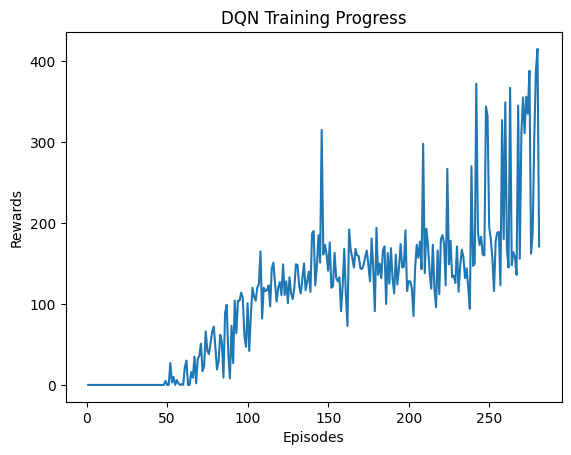

In [9]:

if __name__ == '__main__':
    # Setup the initial environment for training
    game = 'Enduro'
    env_name = 'EnduroNoFrameskip-v4'
    env = gym.make(env_name)
    env = wrap_environment(env, grayscale=True, scale_obs=False, terminal_on_life_loss=True)

    print(torch.cuda.is_available())
    agent = AgentDQN(env)
    agent.train_agent()
    env.close()

    # Setup display for rendering the environment
    display = Display(visible=0, size=(1400, 900))
    display.start()

    # Setup a new environment for testing
    test_env = gym.make(env_name)
    test_env = wrap_environment(test_env, grayscale=True, scale_obs=False, terminal_on_life_loss=False)

    # Start testing the trained agent
    state = torch.from_numpy(np.array(test_env.reset(seed=30))).unsqueeze(0)
    state = state.cuda() if use_cuda else state
    done = False
    total_reward = 0
    step_index = 0

    while not done:
        test_env.render()
        action = agent.test_actions[step_index]
        step_index += 1
        next_state, reward, done, _ = test_env.step(action)

        next_state = torch.from_numpy(np.array(next_state)).unsqueeze(0)
        next_state = next_state.cuda() if use_cuda else next_state

        state = next_state
        total_reward += reward

    print(f'Total reward in this episode: {total_reward}')
    test_env.close()

    # Display the video of the session
    show_video()